<a href="https://colab.research.google.com/github/Germandev55/Topology_and_Geometry-for-Deep-Learning/blob/main/GraphConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

In [ ]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = Planetoid(root='dsets/Cora', name='Cora')
dataset[0]


Processing...
Done!


Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [ ]:
class GraphConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, bias=True):
        super(GraphConvolution, self).__init__(aggr='add') # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels, bias=bias)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-6: Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 6: Return new node embeddings.
        return aggr_out

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(Net, self).__init__()
        self.conv1 = GraphConvolution(nfeat, nhid)
        self.conv2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
nfeat = dataset.num_node_features
nhid = 16
nclass = dataset.num_classes
dropout = 0.5

In [ ]:
print(nfeat, nclass)


1433 7


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(nfeat, nhid, nclass, dropout).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
      print(loss)

tensor(1.9532, grad_fn=<NllLossBackward>)
tensor(0.3134, grad_fn=<NllLossBackward>)
tensor(0.0700, grad_fn=<NllLossBackward>)
tensor(0.0626, grad_fn=<NllLossBackward>)
tensor(0.0529, grad_fn=<NllLossBackward>)
tensor(0.0309, grad_fn=<NllLossBackward>)
tensor(0.0531, grad_fn=<NllLossBackward>)
tensor(0.0340, grad_fn=<NllLossBackward>)
tensor(0.0576, grad_fn=<NllLossBackward>)
tensor(0.0390, grad_fn=<NllLossBackward>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8110


In [ ]:
def plot_dataset(dataset):
    edges_raw = dataset.data.edge_index.numpy()
    edges = [(x, y) for x, y in zip(edges_raw[0, :], edges_raw[1, :])]
    labels = dataset.data.y.numpy()

    G = nx.Graph()
    G.add_nodes_from(list(range(np.max(edges_raw))))
    G.add_edges_from(edges)
    plt.subplot(111)
    options = {
                'node_size': 30,
                'width': 0.2,
    }
    nx.draw(G, with_labels=False, node_color=labels.tolist(), cmap=plt.cm.tab10, font_weight='bold', **options)
    plt.show()

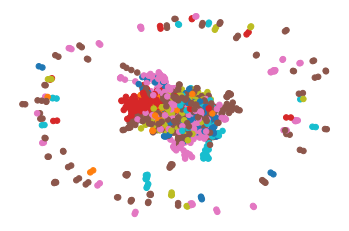

In [ ]:
plot_dataset(dataset)